# Domácí výhoda ve fotbale
Bedřich Mazourek

<br>

Domácí výhoda je fenomén, kdy týmy hrající ve svém domácím stadionu vyhrávají častěji než hosté. 
Tento jev se vysvětluje několika faktory:

- 1) Domácí tým má podporu fanoušků, takže hraje lépe
- 2) Rozhodčí podvědomě pískají méně faulů způsobených domácím týmem, aby na ně nebučelo publikum.
- 3) Domácí tým hraje na svém teritoriu, takže má větší psychologickou sebejistotu
- 4) Jev je sebenaplňující proroctví - domácí hráči očekávají, že vyhrají, takže hrají s větší jistotou, což se poté promítne do výsledku

Během covidové pandemie byly stadiony zavřené a hrálo se bez fanoušků, což poskytlo unikátní příležitost tento fenomén pozorovat, a blíže se podívat na vliv prvních dvou faktorů


## Data
Budu používat následují dva soubory dat:
- 1) Výsledky mezinárodních zápasů od roku 1872 - https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017
- 2) Zápasy evropských lig sezóny 2019/20 - https://osf.io/4hu8r/?view_only=1176423f8b594ddbb0d93b5c45856557


## Příklad 1 - Mezinárodní zápasy

- Nejdříve by mě zajímalo, jestli vskutku můžeme pozorovat nějakou domácí výhodu
- K tomu bude potřeba z dat odfiltrovat pryč zápasy hrané na neutrálním uzemí a zápasy během covidu

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('international_results.csv')
df = df.iloc[::-1]                               # Reverse

df = df.loc[df['neutral'] == False]              # Games played in non-neutral stadiums
pre_covid = df.loc[df['date'] < '2020-01-01']    # Get all matches played before covid (circa 2020)

In [11]:
# Get total number of wins from match results
def get_results(label, home_goals, away_goals): 
    if len(home_goals) != len(away_goals):
        print("Different list sizes")
        return
    
    wins = losses = draws = 0
    for x,y in zip(home_goals, away_goals):
        if x > y: 
            wins += 1
        elif x == y:
            draws += 1
        else:
            losses += 1
    
    pie_chart(label, wins, draws, losses)
    
    return [wins, draws, losses]
    
def pie_chart(label,wins,draws,losses):
    y = [wins,draws,losses]
    mylabels = ['Home', 'Draw', 'Away']
    
    plt.title(label)
    plt.pie(y, labels = mylabels ,shadow=True, autopct='%1.1f%%',)
    plt.show()

Sample size is: 31469 matches played before covid


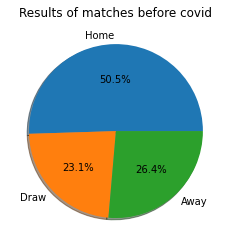

In [66]:
home_goals = pre_covid.iloc[:,3].values     
away_goals = pre_covid.iloc[:,4].values
inter_matches = len(pre_covid)
print(f'Sample size is: {inter_matches} matches played before covid')
results_pre = get_results('Results of matches before covid', home_goals, away_goals);

- Hned můžeme vidět, že rozdělení výher a velikost vzorku velmi silně podporuje hypotézu domácí výhody.
- Nyní by mě zajímalo, jestli jde na stejném datasetu pozorovat nějaká změna výsledků pro období coronaviru, kdy byly stadiony povětšinou zavřené a hrálo se bez fanoušků
  - Z internetových článků napsaných v té době jsem udělal hrubý odhad, že stadiony byly nejvíce zavřené od března 2020 do března 2021. 
  - Samozřejmě průběh pandemie byl v různých částech světa jiný a určitě v tomto období byly i hry s fanoušky, ale můžeme se pokusit o aproximaci

Sample size: 269 matches played during covid


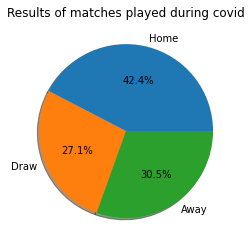

In [10]:
covid = df.loc[df['date'] > '2020-03-01'].loc[df['date'] < '2021-03-01']       # Matches approximately from the most intense covid period
covid_home = covid.iloc[:,3].values     # Home goals during covid
covid_away = covid.iloc[:,4].values     # Away goals during covid
print(f'Sample size: {len(covid)} matches played during covid')
results_cov = get_results('Results of matches played during covid', covid_home, covid_away)

- Přestože je velikost vzorku menší a výběr časového období nejistý, můžeme vidět, že se trend docela výrazně změnil, a domácí vyhráli bez fanoušků pouze 42% her - o 8% méně než předtím 
<br>
</br>
- Pro ověření můžeme použít Pearsonův χ^2 test nezávislosti
- Nulová hypotéza bude, že výsledky zápasů jsou nezávislé na tom, jestli se hrají během období covidu (a tedy v prázdných stadionech), nebo ne
- Zvolme hladinu nezávisloti 5%
- Máme 2 stupně nezávislosti, a tedy kritická hodnota bude 5.99

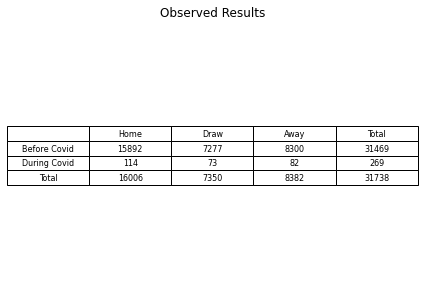

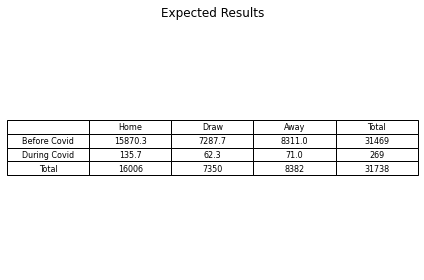

Chi-squared is 7.07, which is larger than the critical value of 5.99. Therefore, we can have enough confidence to reject the null hypothesis 


In [68]:
def test_of_independence(description_x, results_x, description_y, results_y, critical_value): 
    # Visualize the data in tables
    def plot_tables():
        home_x, draw_x, away_x = results_x
        home_y, draw_y, away_y = results_y
        # Get the total number of matches played during both periods
        total_x = home_x + draw_x + away_x      
        total_y = home_y + draw_y + away_y
        
        total_home = home_x + home_y        # Total home wins in both periods
        total_draw = draw_x + draw_y        # Total draws
        total_away = away_x +  away_y       # Total away wins
        total_abs = total_x + total_y       # Absolute total of matches played
        
        #* First table
        fig, ax = plt.subplots()
        fig.patch.set_visible(False) # Hide axes 
        ax.axis('off')
        ax.axis('tight')
        
        cols = ['', 'Home', 'Draw', 'Away', 'Total']
        rows = [[description_x, home_x, draw_x, away_x, total_x],
                [description_y, home_y, draw_y, away_y, total_y],
                ['Total', total_home, total_draw, total_away, total_abs]]


        ax.table(cellText=rows, colLabels=cols, loc='center', cellLoc='center')
        fig.tight_layout()
        plt.title('Observed Results')
        plt.show()
        
        
        #* Second table
        fig2, ax2 = plt.subplots()
        fig2.patch.set_visible(False)
        ax2.axis('off')
        ax2.axis('tight')
        
        # Get the expected results from data
        r1 = [round((x/total_abs) * total_x, 1 ) for x in [total_home, total_draw, total_away]] + [total_x]
        r2 = [round((y/total_abs) * total_y, 1 ) for y in [total_home, total_draw, total_away]] + [total_y]
        
        rows2 = [[description_x] + r1,
                [description_y] + r2,
                ['Total', total_home, total_draw, total_away, total_abs]]
        
        ax2.table(cellText=rows2, colLabels=cols, loc='center', cellLoc='center')

        plt.title('Expected Results')
        fig2.tight_layout()
        plt.show()
        
        return rows, rows2
        
        
    rows, rows2 = plot_tables()    
    # Get the 6 relavant datapoints from each table
    observed_results = rows[0][1:-1] + rows[1][1:-1]
    expected_results = rows2[0][1:-1] + rows2[1][1:-1]
    
    chi_sq = 0
    for obs, exp in zip(observed_results, expected_results):
        chi_sq += (obs - exp)**2 / exp          # Chi-squared formula
    
    if (chi_sq <= critical_value):
        comparison = 'smaller'
        confidence = 'do not'
    else:
        comparison = 'larger'
        confidence = 'can' 
        
    print(f'Chi-squared is {round(chi_sq,2)}, which is {comparison} than the critical value of {critical_value}. Therefore, we {confidence} have enough confidence to reject the null hypothesis ')



test_of_independence('Before Covid', results_pre, 'During Covid', results_cov, 5.99)

- Pomocí testu nezávislosti můžeme zamítnout nulovou hypotézu nezávislosti
- Pro mezinárodní zápasy tedy můžeme mít solidní jistotu, že výsledky jsou vskutku závislé na přítomnosti fanoušků

## Příklad 2 - Evropské ligy
- Nyní se můžeme podívat na výsledky evropských lig, hrané 2019/2020 
- Velká výhoda tohoto datasetu je, že přibližně tři čtvrtiny her se hrály před coronavirem a zbylá čtvrtina během, takže budeme porovnávat jablka s jablky
- Také je v datech přímo řečené, které zápasy se hrály s publikem a které bez, takže teď nemusíme dělat žádné odhady

In [15]:
df2 = pd.read_excel("europe.xlsx")
full = df2.loc[df2['Covid'] == 0].loc[df2['Venue'] == 1]       # Full stadiums before corona
empty = df2.loc[df2['Covid'] == 1].loc[df2['Venue'] == 0]      # Empty stadiums during corona

Sample size is: 3600 matches played before coronavirus


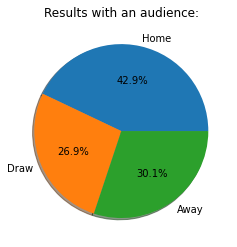

In [19]:
# FTR = Full Time Results
home_wins = full['FTR'].value_counts()['H']     # 'H' = Home Win
draws = full['FTR'].value_counts()['D']         # 'D' = Draw
away_wins = full['FTR'].value_counts()['A']     # 'A' = Away Win

eu_results_pre = [home_wins, draws, away_wins]

print(f'Sample size is: {len(full)} matches played before coronavirus')
pie_chart('Results with an audience:', home_wins, draws, away_wins)

- Okamžitě si můžeme všimnout, že přestože domácí výhodu stále můžeme pozorovat, tak pro evropské ligy je šance výhry domácích o 7% menší než pro mezinárodní zápasy
- Asi je zbytečné spekulovat o tom, proč to tak je, ale jedno vysvětlení by mohlo být, že během mezinárodních zápasů je ve stadionech mnohem více domácích fanoušků než fanouškům hostů.
  - Například pokud hraje Španělsko proti Německu ve španělském stadionu, tak se dá očekávat, že španělských fanoušků bude výrazně více než německých
  - Na druhou stranu při zápase Sparty proti Slávii bude poměr fanoušků relativně rovnoměrný, bez ohledu na to v jakém stadionu se zápas koná
- Každopádně nyní se můžeme podívat na zápasy hrané během coronaviru   

Sample size is: 1414 matches played during coronavirus


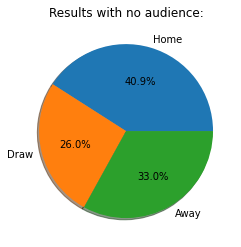

In [30]:
home_wins = empty['FTR'].value_counts()['H'] 
draws = empty['FTR'].value_counts()['D']
away_wins = empty['FTR'].value_counts()['A']

eu_results_cov = [home_wins, draws, away_wins]


print(f'Sample size is: {len(empty)} matches played during coronavirus')
pie_chart('Results with no audience:', home_wins, draws, away_wins)

- Přestože pokles není tak drastický jako u mezinárodních zápasů, znovu můžeme pozorovat snížení domácích výher v prázdných stadionech
- To nám, společně s výsledky mezinárodních zápasů, může dát docela silnou jistotu, že fanoušci mají nezanedbatelný vliv na výsledky zápasů
<br>
</br>
- Pro evropské zápasy můžeme znovu provést test nezávislosti, s hladinou nezávislosti 5%:
- Nulová hypotéza znovu bude, že výsledky zápasů jsou nezávislé na tom, jestli se hrají během covidu nebo ne. 

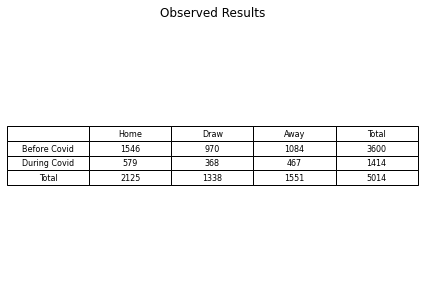

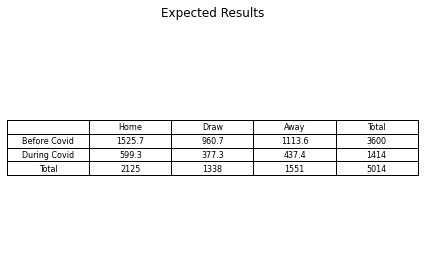

Chi-squared is 4.07, which is smaller than the critical value of 5.99. Therefore, we do not have enough confidence to reject the null hypothesis 


In [65]:
test_of_independence('Before Covid', eu_results_pre, 'During Covid', eu_results_cov, 5.99)

- Pro evropské zápasy můžeme přijmout nulovou hypotézu
- To nám říká, že v evropských ligách není plnost stadionů, a tedy i přítomnost fanoušků, dostatečně významná 

## Příklad 2.5 - Závislost mezi mezinárodními a evropskými zápasy
- Ještě bychom se mohli podívat, jestli jsou výsledky závislé na tom, jestli se hrají buď jako mezinárodní zápas, nebo jako zápas evropské ligy
- Pro výpočet použijeme stejnou funkci jako předtím, a nejdříve se podíváme na zápasy před covidem s plnými stadiony

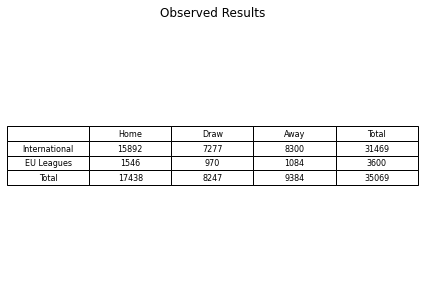

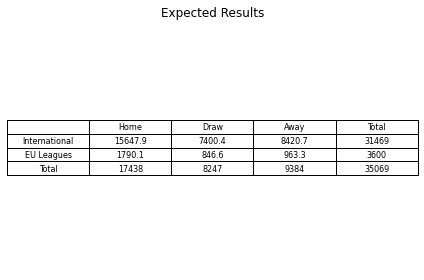

Chi-squared is 73.99, which is larger than the critical value of 5.99. Therefore, we can have enough confidence to reject the null hypothesis 


In [72]:
test_of_independence('International', results_pre, 'EU Leagues', eu_results_pre, 5.99)

- χ^2 vyšlo 74, což je výrazně vyšší než kritická hodnota 5.99
- Z toho můžeme s velmi velkou jistotou zamítnout nulovou hypotézu
- Závěr můžeme učinit takový, že výsledky zápasů (s fanoušky) silně závisí na tom, jestli se hrají mezinárodně anebo v evropské lize

- Obdobně můžeme udělat znovu stejný test, ale v období covidu a bez fanoušků

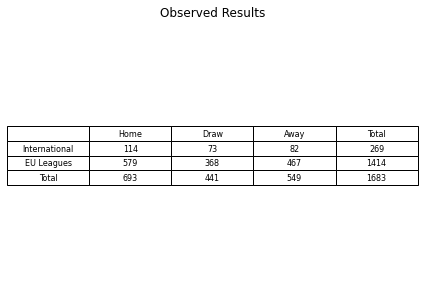

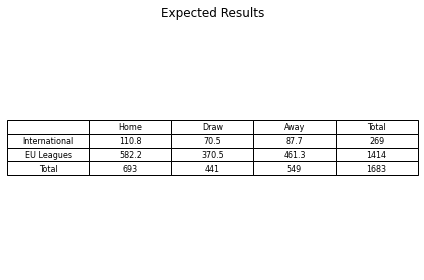

Chi-squared is 0.66, which is smaller than the critical value of 5.99. Therefore, we do not have enough confidence to reject the null hypothesis 


In [73]:
test_of_independence('International', results_cov, 'EU Leagues', eu_results_cov, 5.99)


- χ^2 zde vyšlo velmi malé, obzvlášť v porovnání s předchozím výsledkem 74
- Nulovou hypotézu můžeme přijmout, a říci, že během období covidu bez fanoušků nejsou výsledky závislé na tom, jestli se hraje mezinárodní anebo evropský fotbal 

## Příklad 3 - Chovaní rozhodčích
- Data o evropských zápasech jsou relativně podrobná a obsahují i počty žlutých a červených karet
- Toho můžeme využít a podívat se, jestli rozhodčí vskutku mění své chování podle toho, jestli je přítomno publikum

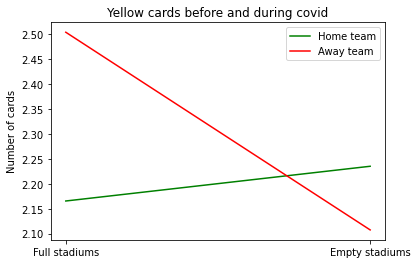

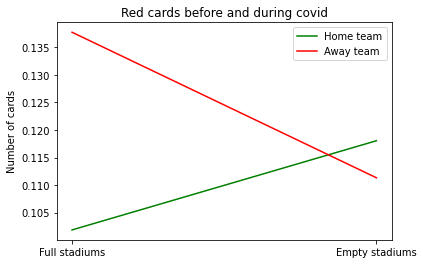

In [9]:
def show_card(card_type):               # card_type = Yellow/Red
    home = 'H' + card_type[0]           # HY = Home Yellow, HR = Home Red
    home_full = get_avg(full, home)     # Home team full stadium
    home_empty = get_avg(empty, home)   # Home team empty stadium
    
    away = 'A' + card_type[0]           # AY = Away Yellow, AR = Away Red
    away_full = get_avg(full, away)     # Away team full stadium
    away_empty = get_avg(empty, away)   # Away team empty stadium
    
    plot_graph([home_full, home_empty], [away_full, away_empty], card_type)
    

# U několika zápasů data o počtu karet chybí, takže průměr spočítáme mírnou oklikou
def get_avg(data, type):
    vals = data[type].values
    suma = 0
    counter = 0
    
    for val in vals:
        try:
            suma += val
            counter += 1
        except TypeError:
            pass
    
    return suma/counter    

def plot_graph(home_stats, away_stats, card_type):
    plt.plot(['Full stadiums', 'Empty stadiums'], home_stats, '-g', label = 'Home team')
    plt.plot(['Full stadiums', 'Empty stadiums'], away_stats, '-r', label = 'Away team')
    
    plt.title(f'{card_type} cards before and during covid')
    plt.ylabel("Number of cards")

    plt.legend()
    plt.show()
    
show_card('Yellow')
show_card('Red')

- Z dat můžeme vidět nárůst počtu karet pro domácí a relativně strmé snížení počtu pro hosty
- Domácí týmy také v prázdných stadionech dostávají více karet než hosté. To by se dalo vysvětlit tím, že na domácí půdě jsou hráči agresivnější, a také jsou zvyklí na to, že jim to obvykle rozhodčí častěji promine

## Závěr
- Můžeme s jistotou říci, že domácí výhoda existuje - z dat jsme viděli 50% šanci výhry mezinárodních zápasů a 43% výhry v evropské lize pro domácí týmy
- Také jsme mohli pozorovat snížení domácí výhody ve stadionech bez publika. Z toho můžeme odvodit, že fanoušci mají vliv na výsledek zápasu
- Jeden pozorovatelný vliv fanoušků je na chování rozhodčích, u nichž můžeme vidět, že bez publika dávájí více karet domácím a méně karet hostům, což má potom vliv na výsledek zápasu
- Velmi zajímavé je, že silnou domácí výhodu lze stále pozorovat i bez fanoušků. Pro evropské ligy to byla pravděpodobnost výhry domácích 41%, zatímco hostů pouze 33%
  - Z toho můžeme vydedukovat, že přestože fanoušci mají vliv, existuje více faktorů. Ať je to sebenapňující proroctví, teritoriální sebejistota, či něco úplně jiného, záhada domácí výhody stále přetrvává 
